In [1]:
import pickle
from lime.lime_text import LimeTextExplainer
import pandas as pd
import numpy as np
from tqdm import tqdm
from lime.explanation import Explanation
from typing import Tuple, List
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from joblib import Parallel, delayed
import gensim
import io
import base64
from IPython.display import display, HTML
import re
import matplotlib.patches as mpatches
scaler = MinMaxScaler()
import hashlib

In [2]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

## Embeddings

In [ ]:
df_all = pd.read_csv("imdb/cleaned_IMDB.csv").rename(columns={"sentiment": "target"})

In [ ]:
def tokenized_column(string_col
                    ):  
    tokenized_list=[]
    for i in list(string_col):
        li = list(i.split(' '))
        tokenized_list.append(li)
    return tokenized_list

In [ ]:
model = gensim.models.word2vec.Word2Vec(tokenized_column(df_all["review"].astype(str)),
                                vector_size=100, 
                                window = 10,
                                min_count=2,
                                sg=1
                                        )
model.save("imdb/w2v_IMDB1.model")

In [ ]:
df_all["target"] = df_all.target.map({"positive": 1, "negative": 0})

In [44]:
# Load the trained logistic regression model trained on IMDB reviews dataset
loaded_model = pickle.load(open("imdb/models_lreg_w2v_avg_.sav", "rb"))
# Load w2v model
model_w2v = pickle.load(open("imdb/w2v_IMDB1.model", "rb"))
# Load the test dataset
test_df = pd.read_csv("imdb/y_test_.csv").drop(columns="Unnamed: 0").rename(columns={"review": "text"})

In [242]:
test_df = test_df[~test_df.text.isna()]

In [35]:
def predict_probabilities_from_text(texts: List[str]) -> np.ndarray:
    """
    Converts a list of texts into feature vectors using a Word2Vec model 
    and predicts probabilities using LR model.
    Parameters:
    - texts (list of str): List of textual data.
    Returns:
    - ndarray: Probabilities predicted by the model for each text.
    """
    vectors = []
    # Convert each text into a feature vector
    for text in texts:
        # Tokenize the text and filter words present in the Word2Vec model
        words = [word for word in text.split() if word in model_w2v.wv]
        # If there are valid words, compute the mean vector
        if words:
            vector = np.mean([model_w2v.wv[word] for word in words], axis=0)
            vectors.append(vector)
        else:
            # If no valid words, append a zero vector
            vectors.append(np.zeros(model_w2v.vector_size))
    # Predict probabilities using the preloaded model
    return loaded_model.predict_proba(vectors)

# LIME applied on test_df

In [244]:
def process_instance(i, text, true_label, word_cache):
    explained = explainer.explain_instance(text, predict_probabilities_from_text, num_features=20)
    lime_word_importances = explained.as_list()
    importances_df = pd.DataFrame(lime_word_importances, columns=["word", "importance"])
    importances_df["true_label"] = true_label
    importances_df["text"] = text
    importances_df["intercept"] = explained.intercept[1]
    importances_df["prediction_local"] = explained.local_pred[0]

    for word in importances_df["word"].unique():
        if word not in word_cache:
            word_cache[word] = {}
            word_cache[word]["predicted_proba"] = predict_probabilities_from_text([word])[0][1]

        importances_df.loc[importances_df["word"] == word, "predicted_proba"] = word_cache[word]["predicted_proba"]

    return importances_df

In [ ]:
# DataFrame to store LIME results
lime_df = pd.DataFrame(columns=["word", "importance", "true_label"])

# Initialize the LIME text explainer
explainer = LimeTextExplainer(class_names=["Negative", "Positive"], random_state=42)

word_cache = {}

# Use all available CPUs
results = Parallel(n_jobs=-1)(delayed(process_instance)(i, text, true_label, word_cache) for i, (text, true_label) in enumerate(tqdm(zip(test_df["text"], test_df["target"]))))

# Combine all results into one dataframe
lime_df = pd.concat(results).reset_index(drop=True)

lime_df.to_csv("imdb/lime_imdb_all_new.csv")

In [25]:
def calculate_word_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates various metrics related to word importance, such as the number of occurrences,
    positive importances, and average importances for high and low citation articles.
    Parameters:
    - df (pd.DataFrame): DataFrame containing word importances and true labels.
    Returns:
    - pd.DataFrame: DataFrame with new columns containing the calculated metrics.
    """
    df['importance'] = df['importance'] + 1 / 2
    df['abs_importance'] = df['importance'].abs()

    # Global LIME Importance (square root of the sum of absolute importance)
    global_lime_importance = np.sqrt(df.groupby('word')['abs_importance'].sum())

    # Global Average Importance
    count_nonzero_importance = df.groupby('word')['abs_importance'].apply(lambda x: (x != 0).sum())
    global_avg_importance = df.groupby('word')['abs_importance'].sum() / count_nonzero_importance

    # Normalize LIME importance per class
    df['normalized_importance'] = df.groupby(['word', 'true_label'])['abs_importance'].transform(lambda x: x / x.sum())

    # Calculate the entropy values for each word based on normalized importance
    grouped = df.groupby(['word', 'true_label'])['normalized_importance'].mean().reset_index()
    grouped = grouped.pivot(index='word', columns='true_label', values='normalized_importance').fillna(0)
    
    # Calculate Shannon entropy for the distribution of normalized importance over classes
    entropy_values = grouped.apply(lambda x: entropy(x + 1e-9), axis=1)

    # Normalize the entropy values
    min_entropy = entropy_values.min()
    max_entropy = entropy_values.max()
    entropy_values_normalized = (entropy_values - min_entropy) / (max_entropy - min_entropy)

    # Calculate the Global Homogeneity-Weighted Importance for each word
    global_homogeneity_importance = (1 - entropy_values_normalized) * global_lime_importance


    total_occurrences = df.groupby('word').size()
    avg_predict_proba = df.groupby('word')['predicted_proba'].mean()

    # Map the calculated metrics back to the original dataframe
    metrics_df = df.assign(
        total_occurrences=df['word'].map(total_occurrences),
        avg_predict_proba=df['word'].map(avg_predict_proba),
        global_lime_importance=df['word'].map(global_lime_importance),
        global_avg_importance= df["word"].map(global_avg_importance),
        global_homogeneity_importance=df['word'].map(global_homogeneity_importance),
    )

    metrics_df.fillna(0, inplace=True)
    return metrics_df


## Load LIME results

In [26]:
lime_df = pd.read_csv("imdb/lime_imdb_all.csv")

In [27]:
def generate_doi(text):
    hash_object = hashlib.md5(text.encode())
    doi_suffix = hash_object.hexdigest()[:8]
    return doi_suffix

# Generate DOI for each unique text
lime_df['doi'] = lime_df['text'].apply(generate_doi)

## Calculate Global Word Metrics

In [28]:
lime_df_word_metrics = calculate_word_metrics(lime_df)

In [9]:
lime_df_word_metrics.sort_values("importance", ascending=False)

,Unnamed: 0,word,importance_norm,true_label,text,intercept,prediction_local,predicted_proba,doi,abs_importance,normalized_importance,total_occurrences,avg_predict_proba,global_lime_importance,global_avg_importance,global_homogeneity_importance
930916,930916,great,0.996423,0,great terribl hate great,0.010492,0.993011,1.000000e+00,f3176295,0.996423,0.000568,9907.0,1.000000e+00,75.386598,0.573649,8.204800
525521,525521,love,0.962129,1,love want love jeff hare richard marcu cast crew,0.097554,0.975885,1.000000e+00,2b104526,0.962129,0.000305,8353.0,1.000000e+00,68.991850,0.569840,5.410820
704560,704560,great,0.958565,1,oz great mad great mad great mad great mad gre...,0.132195,0.936519,1.000000e+00,7e910384,0.958565,0.000244,9907.0,1.000000e+00,75.386598,0.573649,8.204800
414327,414327,great,0.945746,0,reason movi great three.3 10,0.186226,0.886771,1.000000e+00,59652fee,0.945746,0.000539,9907.0,1.000000e+00,75.386598,0.573649,8.204800
669502,669502,great,0.941749,0,bother think movi great supspens,0.180135,0.934318,1.000000e+00,c0f07015,0.941749,0.000537,9907.0,1.000000e+00,75.386598,0.573649,8.204800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246580,246580,plot,0.069968,1,excel plot plot plot shame film hero have good...,0.778371,0.144086,3.148533e-06,86cf95e3,0.069968,0.000062,6665.0,3.148533e-06,55.234863,0.457748,2.624089
523461,523461,bad,0.065689,1,bad lot peopl understand episode.10/10 doubt,0.806178,0.034173,3.893502e-16,b3e0aa90,0.065689,0.000075,11208.0,3.893502e-16,65.383821,0.381428,17.348754
379150,379150,bad,0.062176,0,old 2002 watch episod night bad tv,0.798379,0.187191,3.893502e-16,2733310c,0.062176,0.000018,11208.0,3.893502e-16,65.383821,0.381428,17.348754
949253,949253,bad,0.037437,0,see film midnight bad horror film haunt paul g...,0.867082,0.054760,3.893502e-16,a3d6d920,0.037437,0.000011,11208.0,3.893502e-16,65.383821,0.381428,17.348754


In [10]:
df_word_metrics_no_duplicates = lime_df_word_metrics.drop_duplicates(subset='word', keep='first')

## Evaluate Global Scores - AOPCglobal

In [9]:
# load SMER
df_smer = pd.read_csv("imdb/smer.csv").drop(columns=["Unnamed: 0"])

In [33]:
def remove_words(text, words_to_remove):
    return ' '.join([word for word in text.split() if word not in words_to_remove])

# Define the function to compute the drop in predicted probability for one metric
def compute_AOPCglobal(df, df_abstracts, metric_colname, max_K=10):
    # Sort words by their global importance
    ranked_words_global = df.groupby("word")[metric_colname].mean().sort_values(ascending=False).index.tolist()
    
    # Storage for the average drop in probability for each K
    avg_drops = []
    
    # Iterate for each K
    for K in tqdm(range(0, max_K + 1)):
        # Compute the drop in probability for each document
        drops = []
        for text in df_abstracts["text"].unique():
            # Find the top K globally ranked words that are present in this document
            words_in_text = set(text.split())
            top_words_in_text = [word for word in ranked_words_global if word in words_in_text][:K]
            
            altered_text = remove_words(text, top_words_in_text)
            
            # If no change in the text, no need to predict again
            if text == altered_text:
                drop = 0
            else:
                original_pred = predict_probabilities_from_text([text])[0][1]
                altered_pred = predict_probabilities_from_text([altered_text])[0][1]
                drop = original_pred - altered_pred
            
            drops.append(drop)
        
        # Average drop
        avg_drops.append(np.mean(drops))
    
    return avg_drops


### Compute AOPCglobal for SMER score

In [94]:
AOPC_SMER = compute_AOPCglobal(df_smer, lime_df_word_metrics, 'score', max_K=10)

### Compute AOPCglobal for LIME scores

In [45]:
# Compute AOPCglobal for LIME
AOPC_Avg = compute_AOPCglobal(lime_df_word_metrics, lime_df_word_metrics, "global_avg_importance", max_K=10)

100%|██████████| 11/11 [04:00<00:00, 21.84s/it]


### Compute AOPCglobal to obtain Random Baseline

In [47]:
random_ranked_words = lime_df_word_metrics["word"].unique()
np.random.seed(40)
np.random.shuffle(random_ranked_words)
random_df = lime_df_word_metrics.copy()
random_df["random_importance"] = random_df["word"].map({word: rank for rank, word in enumerate(random_ranked_words)})

AOPC_Random = compute_AOPCglobal(random_df, lime_df_word_metrics, "random_importance", max_K)

100%|██████████| 11/11 [04:00<00:00, 21.87s/it]


## Calculate Area Under AOPCglobal

In [71]:
df_results = pd.DataFrame({
"AOPC_RANDOM": AOPC_Random,
"AOPC_AVG": AOPC_Avg ,
"AOPC_SMER": AOPC_SMER,
})

In [55]:
def area_between_curves(df, curve1, curve2):
    return 0.5 * sum([(df[curve1][i] + df[curve1][i-1] - df[curve2][i] - df[curve2][i-1]) for i in range(1, len(df[curve1]))])

results = pd.DataFrame({
    "area_under_APOC_smer": area_between_curves(df_results, "AOPC_SMER", "AOPC_RANDOM"),
    "area_under_APOC_avg_lime": area_between_curves(df_results, "AOPC_AVG", "AOPC_RANDOM"),
}, index=[0])

results_transposed = results.T
results_transposed.columns = ['value']
results_transposed

,value
area_under_APOC_smer,1.813304
area_under_APOC_avg_lime,0.740257


## Plot all AOPCglobal curves

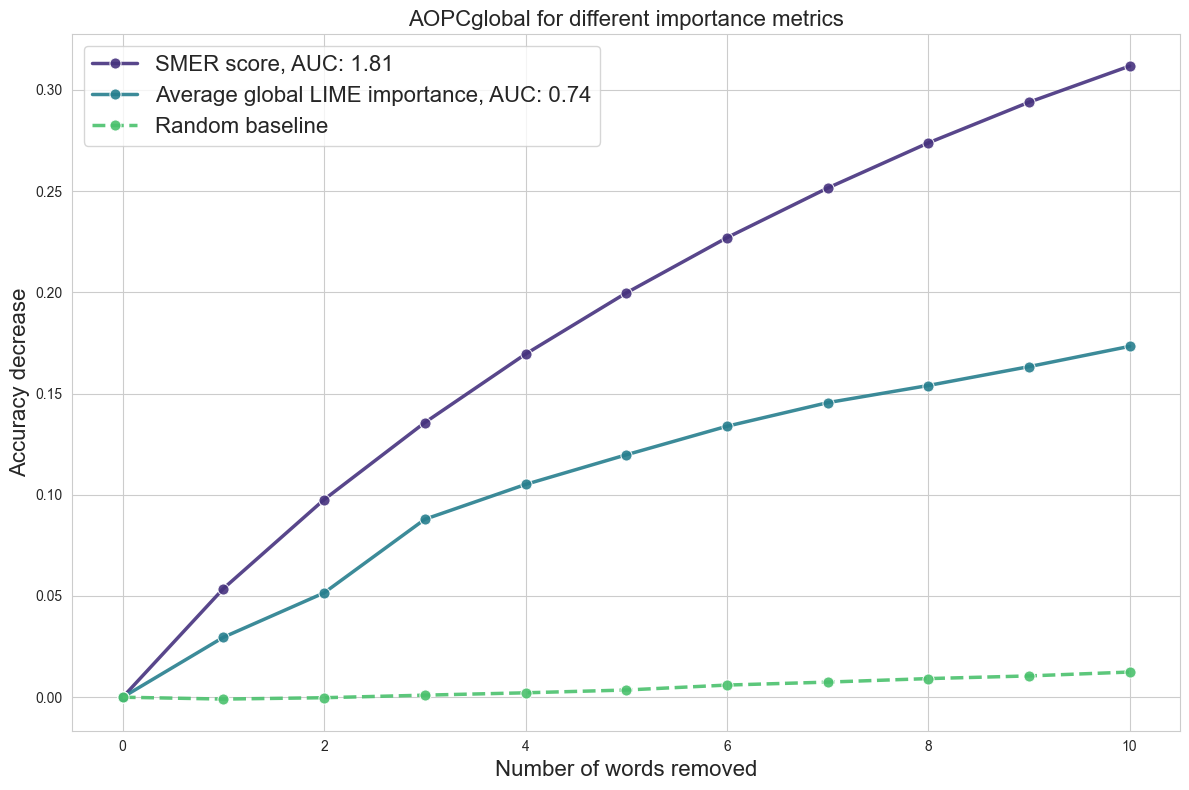

In [73]:
colors = sns.color_palette("viridis")

plt.figure(figsize=(12, 8))
def plot_AOPCglobal(ax, values, label, linestyle, marker, color):
    sns.lineplot(x=range(0, 11), y=values, ax=ax, label=label, linestyle=linestyle, marker=marker, color=color, linewidth=2.5, markersize=8, alpha=0.9)

sns.set_style("whitegrid")
ax = plt.gca()

plot_AOPCglobal(ax, df_results.AOPC_SMER, f'SMER score, AUC: {results.loc[0, "area_under_APOC_smer"].round(2)}', '-', 'o', colors[0])
plot_AOPCglobal(ax, df_results.AOPC_AVG, f'Average global LIME importance, AUC: {results.loc[0, "area_under_APOC_avg_lime"].round(2)}', '-', 'o', colors[2])
plot_AOPCglobal(ax, df_results.AOPC_RANDOM, f'Random baseline', '--', 'o', colors[4])

# Setting labels, title, and legend
ax.set_xlabel('Number of words removed', fontsize=16)
ax.set_ylabel('Accuracy decrease', fontsize=16)
ax.set_title('AOPCglobal for different importance metrics', fontsize=16)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=16)

plt.tight_layout()
plt.show()

In [29]:
lime_df_word_metrics_merged = pd.merge(lime_df_word_metrics, df_smer[['word', 'score']], on='word', how='left')

In [30]:
def scale_column(column_name, new_column_name):
        scaler = MinMaxScaler(feature_range=(0, 0.5))
        mask_below = lime_df_word_metrics_merged[column_name] < 0.5
        lime_df_word_metrics_merged.loc[mask_below, new_column_name] = scaler.fit_transform(lime_df_word_metrics.loc[mask_below, column_name].values.reshape(-1, 1)).flatten()

        scaler.feature_range = (0.5, 1.0)
        mask_above = lime_df_word_metrics_merged[column_name] >= 0.5
        lime_df_word_metrics_merged.loc[mask_above, new_column_name] = scaler.fit_transform(lime_df_word_metrics.loc[mask_above, column_name].values.reshape(-1, 1)).flatten()

scale_column('importance', 'importance_norm')

In [36]:
lime_df_word_metrics_merged['global_avg_importance_scaled'] = scaler.fit_transform(lime_df_word_metrics_merged["global_avg_importance"].values.reshape(-1, 1))

lime_df_word_metrics_merged['importance_scaled'] = scaler.fit_transform(lime_df_word_metrics_merged["importance_norm"].values.reshape(-1, 1))

In [32]:
def fetch_text_by_doi(doi, df):
    if 'text' not in df.columns:
        raise ValueError("DataFrame does not contain 'text' column.")
    result = df[df['doi'] == doi]['text']
    if result.empty:
        raise ValueError(f"No record found for DOI: {doi}")

    return result.iloc[0]


def colorize_importance(importance, rank, decrease_amount=0.05, max_alpha=1.0):
    if importance > 0.5:
        alpha = max_alpha - rank * decrease_amount
        return f'rgba(255, 164, 56, {alpha})'
    else:
        alpha = max_alpha - rank * decrease_amount
        return f'rgba(135, 180, 250, {alpha})'


def colorize_importance_stacked_plot(importance, rank, decrease_amount=0.05, max_alpha=1.0):
    orange = (1.0, 140/255, 0)
    light_blue = (135/255, 206/255, 250/255)
    alpha = max_alpha - rank * decrease_amount
    alpha = max(0, alpha)
    return (orange + (alpha,)) if importance > 0 else (light_blue + (alpha,))


def colorize_importance_plot(importance, rank, total_ranks, decrease_amount=0.1, max_alpha=1.0, min_alpha=0.2):
    orange = (255, 140, 0) 
    light_blue = (135, 206, 250) 
    alpha = max_alpha - ((total_ranks - rank) * decrease_amount)
    alpha = min(max(alpha, min_alpha), max_alpha)
    orange_scaled = tuple([o / 255 for o in orange]) + (alpha,)
    light_blue_scaled = tuple([lb / 255 for lb in light_blue]) + (alpha,)

    return orange_scaled if importance > 0.5 else light_blue_scaled


def highlight_abstract_words(abstract, words_df):
    # Sort the words by importance so the most important words are highlighted first.
    words_df = words_df.sort_values(by='final_importance', ascending=False)

    for idx, (_, row) in enumerate(words_df.iterrows()):
        importance = row['final_importance']
        word = re.escape(row['word'])
        hue = colorize_importance(importance, rank=idx)
        text_color = 'white' if importance < 0.5 else 'black'
        
        def replacement_func(match):
            whole_word_match = rf'\b{match.group()}\b'
            if re.fullmatch(whole_word_match, match.group()):
                return f'<span style="background-color:{hue}; color:{text_color};">{match.group()}</span>'
            else:
                return match.group()
        
        pattern = rf'\b{word}\b'
        compiled_pattern = re.compile(pattern, re.IGNORECASE)
        abstract = compiled_pattern.sub(replacement_func, abstract)
    
    return abstract
    
def determine_importance(doi, df, global_importance_col, threshold, use_smer=False):
    subset = df[df['doi'] == doi].copy()
    if use_smer:
        subset['final_importance'] = np.where(
        abs(subset['importance_scaled'] - subset["score"]) < 0.4,
        subset["score"],
        subset['importance_scaled']
    )
    else:
        subset['final_importance'] = np.where(
            abs(subset['importance_norm'] - subset[global_importance_col]) < threshold,
            subset[global_importance_col],
            subset['importance_norm']
        )
    return subset


def plot_stacked_importance_chart(df, use_smer=False):
    sns.set_style("whitegrid")
    
    # Determine sorting column and calculate differences
    sort_by_col = 'smer_score' if use_smer else 'global_importance'
    df['base_importance'] = df[sort_by_col] - 0.5
    df['difference'] = df['local_importance'] - df[sort_by_col]
    df['local_shifted'] = df['local_importance'] - 0.5
    df['rank'] = df['base_importance'].abs().rank(method='first', ascending=False)
    df = df.sort_values('rank', ascending=True)

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, len(df)))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    #fig.patch.set_alpha(0)
    ax.set_frame_on(False)
    df.set_index('word', inplace=True)

    ax.barh(df.index, df['base_importance'], left=0.5, color='grey', edgecolor='none', alpha=0.9)

    for idx, (word, row) in enumerate(df.iterrows()):
        rank = row['rank']
        color = colorize_importance_stacked_plot(row['difference'], rank)
        global_bar_value = row['base_importance']
        local_bar_value = row['local_shifted']
        global_bar_end = 0.5 + global_bar_value
        local_bar_end = 0.5 + local_bar_value
        
        if abs(global_bar_value) > abs(local_bar_value):
            ax.barh(word, global_bar_value, left=0.5, color='grey', edgecolor='none', alpha=0.9)
            ax.barh(word, local_bar_value, left=0.5, color=color, edgecolor='none', alpha=0.9)
        else:
            ax.barh(word, local_bar_value, left=0.5, color=color, edgecolor='none', alpha=0.9)
            ax.barh(word, global_bar_value, left=0.5, color='grey', edgecolor='none', alpha=0.9)

        
        if abs(global_bar_end - 0.5) > abs(local_bar_end - 0.5):
            label_x_position = global_bar_end
        else:
            label_x_position = local_bar_end

        if label_x_position < 0.5:
            text_align = 'right'
            label_padding = -0.001
        else:
            text_align = 'left'
            label_padding = 0.001

        # Place the word label
        ax.text(label_x_position + label_padding, idx - 0.2, word, va='center', ha=text_align, color='black', fontsize=18)
        # Place the global and local value labels
        text = f'Global: {global_bar_value + 0.5:.2f}, Local: {local_bar_value + 0.5:.2f}'
        ax.text(label_x_position + label_padding, idx + 0.2, text, va='center', ha=text_align, color='grey', fontsize=14)
    
    ax.set_title(f'Global {"SMER" if use_smer else "LIME"} importance vs rescaled local LIME importance', fontsize=16, fontweight='bold', color="black")
    global_patch = mpatches.Patch(color='grey', label=f"Global{' SMER' if use_smer else ' LIME'} importance")
    local_smaller_patch = mpatches.Patch(color='lightblue', label='Local importance smaller than global')
    local_bigger_patch = mpatches.Patch(color='orange', label='Local importance bigger than global')
    ax.legend(handles=[global_patch, local_smaller_patch, local_bigger_patch], loc='best', fontsize=13)
    max_importance = max(df['base_importance'].abs().max(), df['local_shifted'].abs().max())
    x_min = 0.5 - max_importance - 0.05
    x_max = 0.5 + max_importance + 0.05
    ax.set_xlim([x_min, x_max])
    ax.axvline(x=0.5, color='gray', linewidth=1, linestyle='-')
    plt.gca().invert_yaxis() 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([0.5])
    ax.set_xticklabels(['0.5'], fontsize=12, color='grey')

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=150, transparent=True)
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')

    return f'<img src="data:image/png;base64,{img_base64}" alt="Bar chart"/>'


def display_stacked_importance_chart(doi, df, use_smer=False, threshold=0.1, global_importance_col="global_avg_importance"):
    relevant_words_df = determine_importance(doi, df, global_importance_col, threshold, use_smer)
    if use_smer:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['score'] - 0.5)
    else:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['final_importance'] - 0.5)
    
    relevant_words_df = relevant_words_df.sort_values(by='distance_from_center', ascending=False)
    data_for_plot = pd.DataFrame([
        {
            "word": row['word'],
            "global_importance": row[f"{global_importance_col}_scaled"] if use_smer else row[global_importance_col],
            "local_importance": row["importance_scaled"] if use_smer else row["importance_norm"],
            "smer_score": row['score']
        }
        for _, row in relevant_words_df.iterrows()
    ])
    img_html_lime = plot_stacked_importance_chart(data_for_plot, use_smer)
    display(HTML(f"""
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 1000px; word-wrap: break-word; overflow-y: auto;'>
                {img_html_lime}
            </div>
        </div>
    """))


def compute_word_scores_for_abstract(abstract, df, column='score', top_n=15):
    words = pd.Series(abstract.split()).unique()
    word_scores = []

    for word in words:
        scores = df[df['word'] == word][column].unique()
        if scores.size > 0:
            average_score = np.mean(scores)
            word_scores.append((word, average_score, abs(average_score - 0.5)))

    sorted_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(sorted_words, columns=['word', "final_importance", 'distance_from_center'])


def compute_word_scores_for_abstract(abstract, df, column='score', top_n=15, absolute=False):
    words = pd.Series(abstract.split()).unique()
    word_scores = []

    for word in words:
        scores = df[df['word'] == word][column].unique()
        if scores.size > 0:
            average_score = np.mean(scores)
            word_scores.append((word, average_score, abs(average_score - 0.5)))

    if absolute:
        sorted_words = sorted(word_scores, key=lambda x: abs(x[1] - 0.5))
        half_n = top_n // 2
        final_words = sorted_words[:half_n] + sorted_words[-half_n:]
    else:
        final_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]

    return pd.DataFrame(final_words, columns=['word', "final_importance", 'distance_from_center'])


def colorize_importance_bar_plots(importance, rank, total_ranks, max_alpha=1.0):
    orange = (255/255, 140/255, 0)
    light_blue = (135/255, 180/255, 250/255)
    alpha_scale = rank / total_ranks
    alpha = max_alpha * max((rank / total_ranks), 0.2)

    return (orange + (alpha,)) if importance > 0.5 else (light_blue + (alpha,))

    

def plot_importance_bar_chart(data, use_smer=False, include_smer_scores=False, threshold=0.1):
    sns.set_style("white")
    if use_smer:
        data = [item for item in data if np.isfinite(item['smer_score'])]
    else:
        data = [item for item in data if np.isfinite(item['final_importance'])]

    data = data[::-1]
    words = [item['word'] for item in data]
    importance = [item['smer_score'] if use_smer else item['final_importance'] for item in data]
    importance_shifted = [(value - 0.5) for value in importance]

    fig, ax = plt.subplots(figsize=(6, len(data) * 0.8))
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    bar_colors = [colorize_importance_plot(value, idx, len(data) - 1) for idx, value in enumerate(importance)]
    bars = ax.barh(words, importance_shifted, color=bar_colors, edgecolor='none')
    for bar in bars:
        bar.set_linewidth(0.5)

    for index, value in enumerate(importance_shifted):
        word_label = words[index]
        local_metric = f'{value + 0.5:.3f}'
        global_metric = f'{data[index]["global_importance"]:.3f}'

        if use_smer:
            diff = abs(data[index]["local_importance"] - data[index]["smer_score"]) > 0.4
            importance_label = f'SMER: {importance[index]:.3f}' + (f' LIME: {data[index]["local_importance"]:.3f}' if diff else "")
        else:
            diff = abs(data[index]["local_importance"] - data[index]["global_importance"]) > threshold
            importance_label = f"{'LIME' if diff else 'GLIME'}: {local_metric}"
            if diff:
                importance_label += f" (GLIME: {global_metric})"

        if include_smer_scores and not use_smer:
            importance_label += f' SMER: {data[index]["smer_score"]:.3f}'
        # Display the word
        ha_position = 'right' if value < 0 else 'left'
        ax.text(value - 0.005 if value < 0 else value + 0.005, index + 0.2, word_label, color='black', va='center', ha=ha_position, fontsize=18, fontweight='bold')
        # Display the importance value
        label_color = 'red' if diff else 'grey'
        ax.text(value - 0.005 if value < 0 else value + 0.005, index - 0.2, importance_label, color=label_color, va='center', ha=ha_position, fontsize=14)


    max_shift_abs = abs(max(importance_shifted, key=abs))
    padding = 0.1
    ax.set_xlim(-max_shift_abs - padding, max_shift_abs + padding)
    ax.axvline(0, color='grey', lw=1)
    ax.set_xticks([0])
    ax.set_xticklabels(['0.5'], fontsize=12, color='grey')

    positive_handle = mpatches.Patch(color=colorize_importance_plot(1, 14, len(data)), label='Positive sentiment')
    negative_handle = mpatches.Patch(color=colorize_importance_plot(0, 14, len(data)), label='Negative sentiment')

    ax.legend(handles=[positive_handle, negative_handle], loc='best', fontsize=12)
    title_text = ('Rescaled word importance' if not use_smer else 'Word importance')  + (' SMER' if use_smer else ' LIME') + (' with SMER Scores' if include_smer_scores and not use_smer else '')
    ax.set_title(title_text, fontsize=16, fontweight='bold', y=1.02, color='black')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])

    # Save the figure into an image buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=150)
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')

    return f'<img src="data:image/png;base64,{img_base64}" alt="Bar chart"/>'


    
def plot_importance_bar_charts_with_smer(data, use_smer=False):
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(6, len(data) * 0.8))
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    importance_shifted_values = []
    for index, item in enumerate(data):
        word = item['word']
        importance = item['final_importance']
        importance_shifted = importance - 0.5
        importance_shifted_values.append(importance_shifted)
        # Determine color based on importance
        color = colorize_importance_bar_plots(importance, index, len(data) - 1)

        # Adjust bar position
        bar_position = 0.5 if importance_shifted > 0 else 0.5 + importance_shifted
        ax.barh(word, abs(importance_shifted), left=bar_position, color=color, edgecolor='none')

        # Adjust text positioning and padding
        label_x_padding = 0.005
        label_x_position = (0.5 + importance_shifted + label_x_padding) if importance_shifted > 0 else (0.5 + importance_shifted - label_x_padding)
        ha_position = 'left' if importance_shifted > 0 else 'right'

        # Display the word and importance value
        ax.text(label_x_position, index + 0.2, f"{word}", va='center', ha=ha_position, fontsize=18, color='black', fontweight='bold')
        ax.text(label_x_position, index - 0.2, f"{importance:.2f}", va='center', ha=ha_position, fontsize=18, color='grey')

    positive_handle = mpatches.Patch(color=colorize_importance_bar_plots(1, 14, len(data)), label='Positive sentiment')
    negative_handle = mpatches.Patch(color=colorize_importance_bar_plots(0, 14, len(data)), label='Negative sentiment')
    ax.legend(handles=[positive_handle, negative_handle], loc='upper left', fontsize=12)

    max_shift_abs = abs(max(importance_shifted_values, key=abs))
    padding = 0.1
    ax.set_xlim(0.5 - max_shift_abs - padding, 0.5 + max_shift_abs + padding)
    ax.axvline(0.5, color='grey', lw=1)
    ax.set_xticks([0.5])
    ax.set_xticklabels(['0.5'], fontsize=12, color='grey')
    ax.set_title('Global word importance' + f"{' SMER' if use_smer else ' LIME'}", fontsize=16, fontweight='bold', color='black')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])

    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=150)
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')

    return f'<img src="data:image/png;base64,{img_base64}" alt="Bar chart"/>'


def display_plots_with_abstract(doi, df, global_importance_col="global_avg_importance_scaled", absolute=False):
    abstract = fetch_text_by_doi(doi, df)
    
    # LIME
    lime_words_df = compute_word_scores_for_abstract(abstract, df, column=global_importance_col, absolute=absolute)
    lime_words_df = lime_words_df.sort_values(by='final_importance')
    highlighted_abstract_lime = highlight_abstract_words(abstract, lime_words_df)
    img_html_lime = plot_importance_bar_charts_with_smer(lime_words_df.to_dict(orient='records'))

    # SMER
    smer_words_df = compute_word_scores_for_abstract(abstract, df, column='score', absolute=absolute)
    smer_words_df = smer_words_df.sort_values(by='final_importance')
    highlighted_abstract_smer = highlight_abstract_words(abstract, smer_words_df)
    img_html_smer = plot_importance_bar_charts_with_smer(smer_words_df.to_dict(orient='records'), use_smer=True)

    display(HTML(f"""
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 600px; word-wrap: break-word; overflow-y: auto;'>
                {img_html_lime}
            </div>
            <div style='flex: 3; padding: 10px; padding-top: 20px; max-width: 800px; word-wrap: break-word; font-size: 1.2em;'>
                <h2>Explained instance</h2>
                <h4> ID: {doi}</h4>
                {highlighted_abstract_lime}
            </div>
        </div>
        </br>
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 600px; word-wrap: break-word; overflow-y: auto;'>
                {img_html_smer}
            </div>
            <div style='flex: 3; padding: 10px; padding-top: 20px; max-width: 800px; word-wrap: break-word; font-size: 1.2em;'>
                <h2>Explained instance</h2>
                <h4> ID: {doi}</h4>
                {highlighted_abstract_smer}
            </div>
        </div>
    """))


def display_abstract_with_highlights(doi, df, use_smer=False, threshold=0.1, include_smer_scores=False, global_importance_col="global_avg_importance"):
    abstract = fetch_text_by_doi(doi, df)
    relevant_words_df = determine_importance(doi, df, global_importance_col, threshold, use_smer)
    if use_smer:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['score'] - 0.5)
    else:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['final_importance'] - 0.5)
    
    relevant_words_df = relevant_words_df.sort_values(by='distance_from_center', ascending=False)
    highlighted_abstract = highlight_abstract_words(abstract, relevant_words_df)
    data_for_plot = [
    {
        "word": row['word'],
        "final_importance": row['final_importance'],
        "global_importance": row[f"{global_importance_col}_scaled"] if use_smer else row[global_importance_col],
        "local_importance": row["importance_scaled"] if use_smer else row["importance_norm"],
        "smer_score": row['score']
    }
    for _, row in relevant_words_df.iterrows()
]
    img_html = plot_importance_bar_chart(data_for_plot, use_smer, include_smer_scores, threshold)

    display(HTML(f"""
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 700px; word-wrap: break-word; overflow-y: auto;'>
                {img_html}
            </div>
            <div style='flex: 3; padding: 10px; padding-top: 20px; max-width: 800px; word-wrap: break-word; font-size: 1.2em;'>
                <h2>Explained instance</h2>
                <h4> ID: {doi}</h4>
                {highlighted_abstract}
            </div>
        </div>
    """))


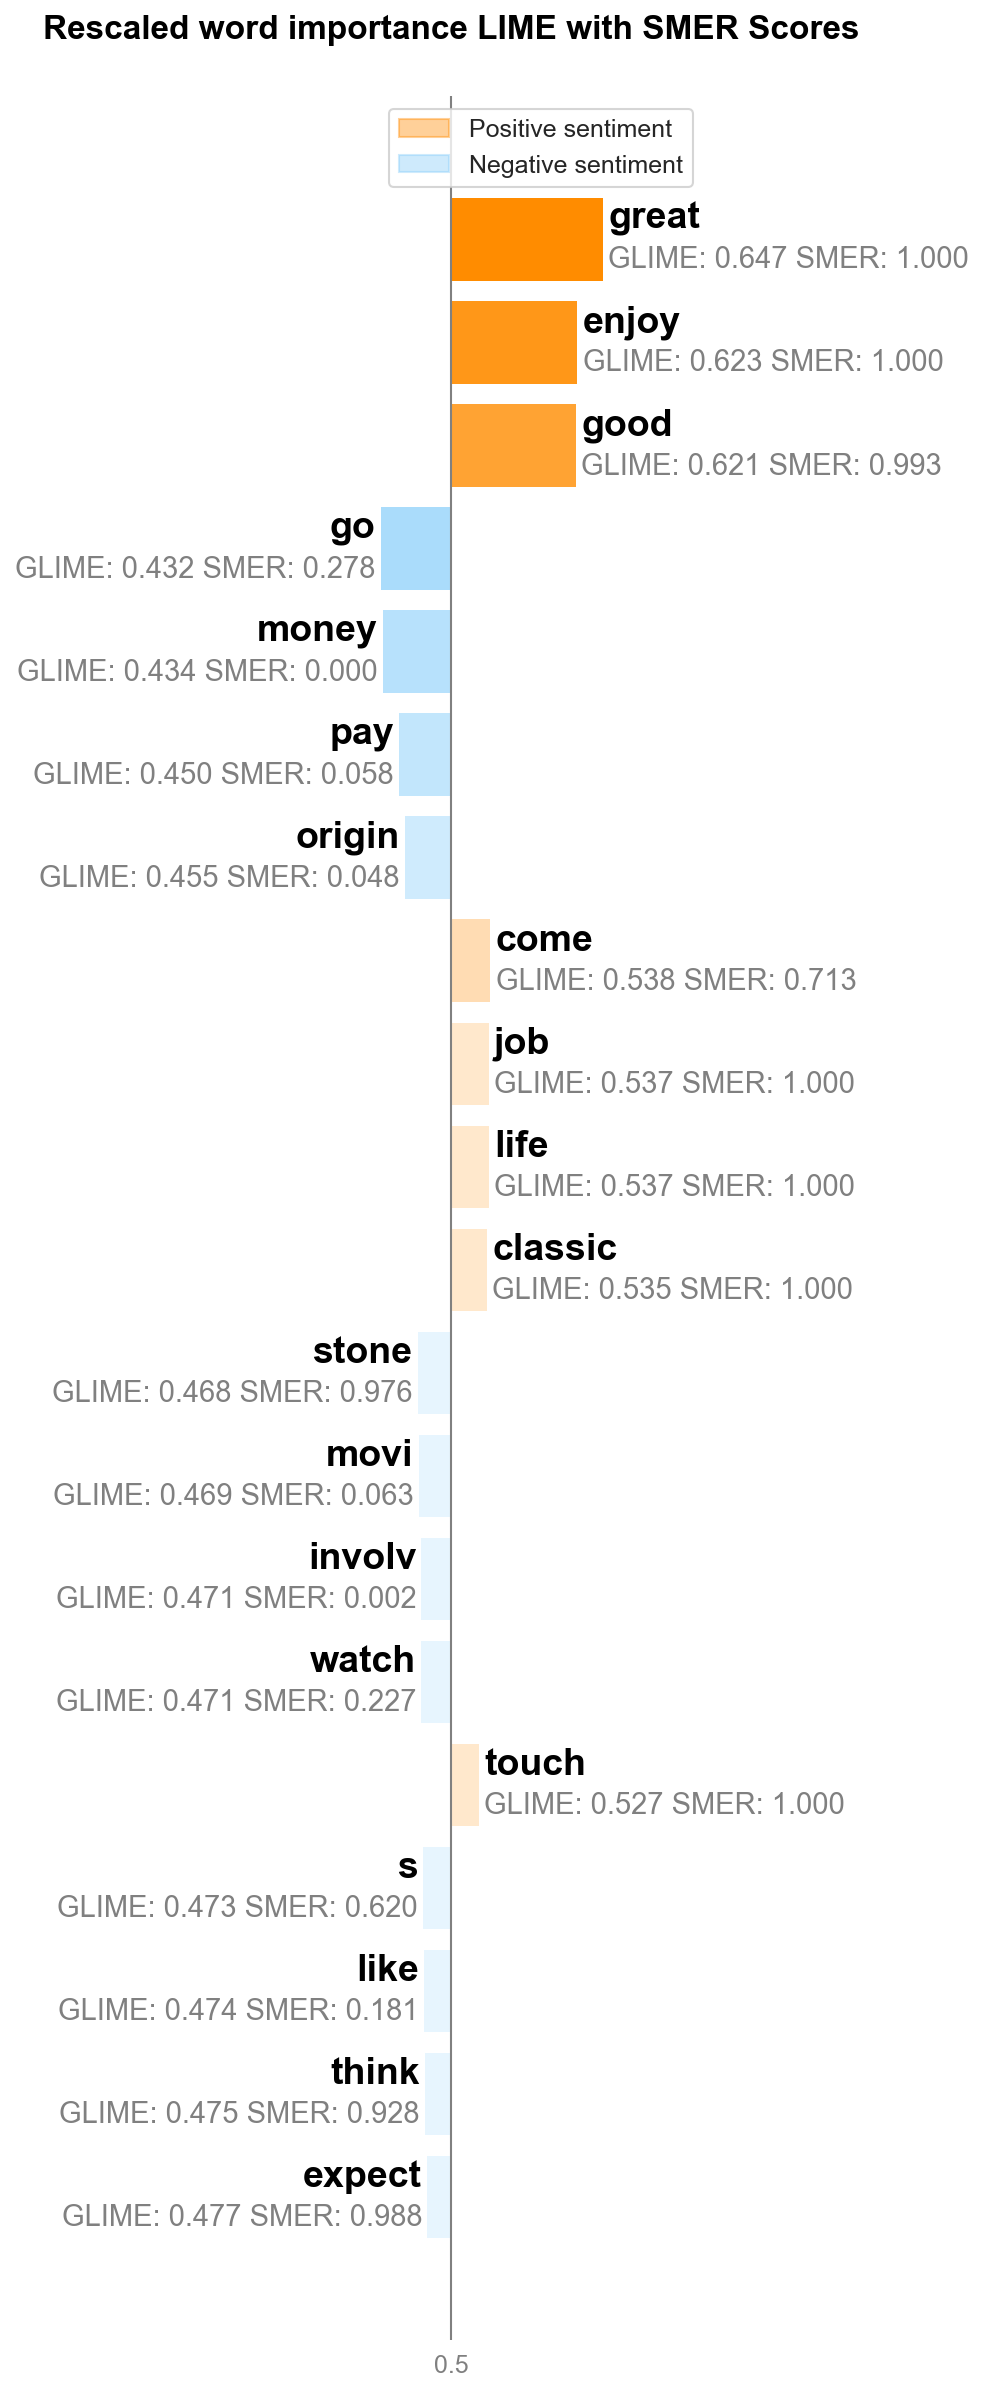

In [33]:
# insert doi of abstarct a04ea145, f25a5144, 10fe43f3, 657eb87a
doi_of_interest = "657eb87a"
include_smer_scores = True
threshold = 0.1
use_smer = False

display_abstract_with_highlights(doi_of_interest, lime_df_word_metrics_merged, use_smer, threshold, include_smer_scores)


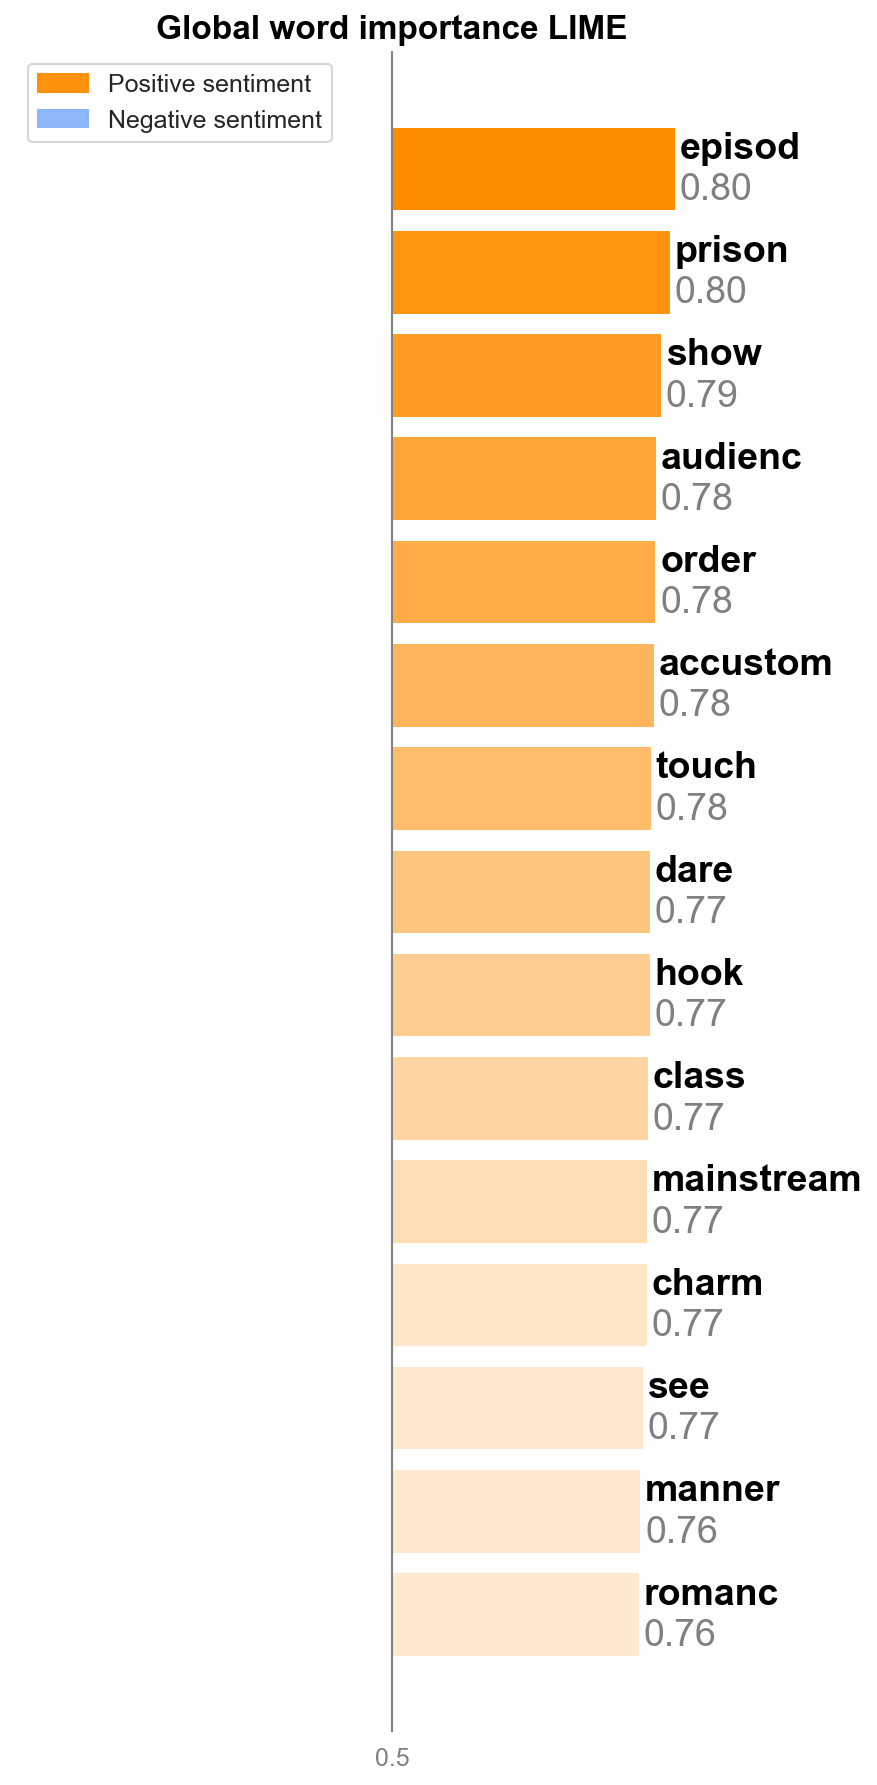
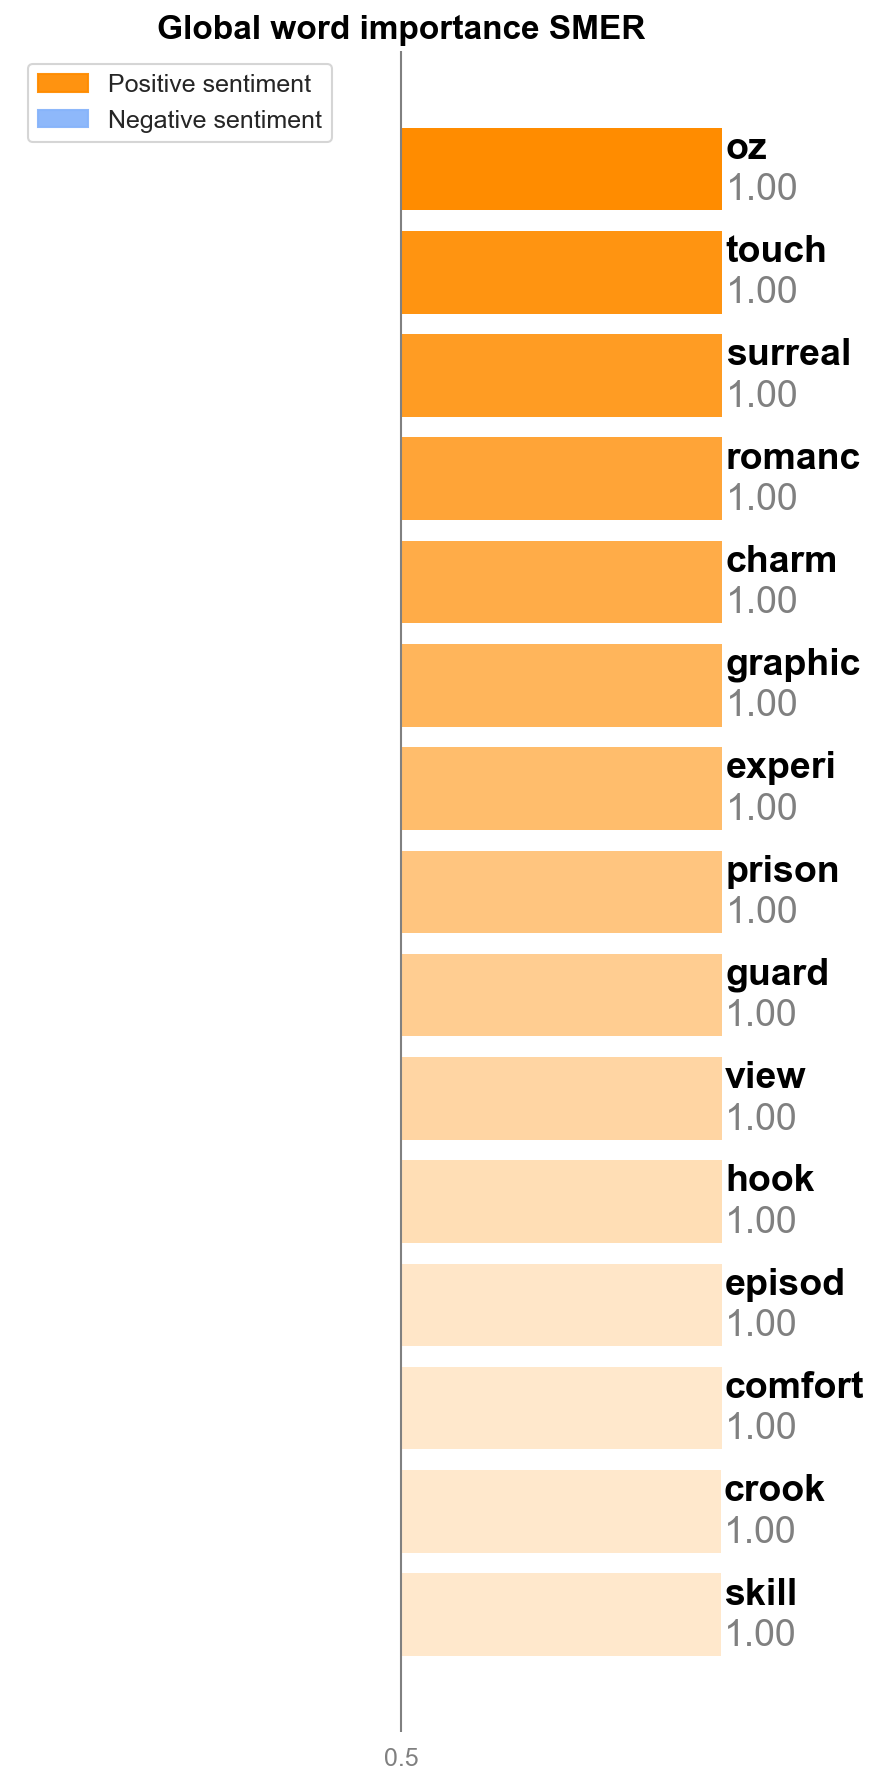

In [37]:
doi_of_interest = "9530ad2a"
absolute=False

display_plots_with_abstract(doi_of_interest, lime_df_word_metrics_merged, absolute=absolute)